In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
import cvxpy as cp
import math
import matplotlib
from random import shuffle

## Semi discrete optimal transport

$$
\begin{align}
\text{min} \big\{ \int_X \sum_j c_{T}(x, y_j) d\gamma_j(x) : \int_X d\gamma_j(x) = \nu_j, \sum_j d\gamma_j(x) = d\mu(x) \big\}
\end{align}
$$

where
- $\mu(x) \sim X$ is a continuous distribution
- $\nu \sim Y$ is a discrete distribution
- $c_T(x, y_j) = \frac{1}{2}(x - y_j)^2$ is the cost function

## Generate a problem

**Continuous distribution $\mu(x) \sim X = N(0, 1)$**

In [2]:
S = 10000
s = np.random.randn(S)
s.sort()

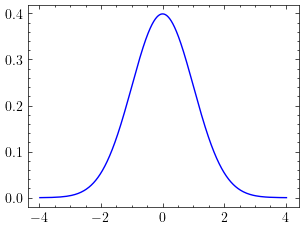

In [3]:
cdfs = stats.norm.pdf(s)
plt.plot(s, cdfs, color = "blue")
plt.show()

Discretize $s \sim S$ to compute the integrals with $P(X = x_i) = \frac{1}{M} \sum_j \mathbb{1}_{(-\infty, x_i ]} (s_j)$

In [4]:
def discretize(s, M):
    S = s.size
    s_min = s.min()
    s_max = s.max()
    x = np.zeros(M)
    x_int = {}
    size = (s_max - s_min) / M
    sum_x = 0.0
    for i in range(M):
        a = s_min + i * size
        b = s_min + (i + 1) * size
        x_int[i] = (a, b)
        x[i] = 0.
        for k in range(S):
            if s[k] >= a and s[k] < b:
                x[i] += 1
        sum_x += x[i]
    for i in range(M):
        x[i] /= sum_x
    return x, x_int

In [5]:
M = 100
x,_ = discretize(s, M)

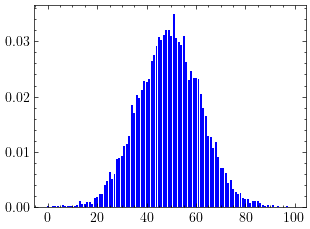

In [6]:
plt.bar(range(M), x, color = "blue")
plt.show()

**Discrete distribution $\nu \sim Y$**

In [7]:
def generate_dist(N, S = 10000):
    y = np.zeros(N)
    s = np.random.randn(S)
    y_dist, _ = discretize(s, N//2)
    for i in range(N//2):
        y[i] = y_dist[i]
        y[i + N//2] = y_dist[i]
    y = y / y.sum()
    return y

In [8]:
N = 100
if N % 2 > 0:
    N += 1
y = generate_dist(N)

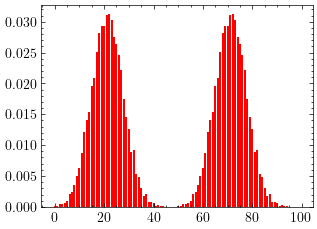

In [9]:
plt.bar(range(N), y, color = "red")
plt.show()

## Distance matrix

$$C = d(x_i, y_j) = \frac{1}{2}(x_i - y_j)^2$$

$$i = \{1, 2, \ldots, M\} \ \text{and} \ j = \{1, 2, \ldots, N\}$$

In [10]:
C = np.zeros((M, N))
for i in range(M):
    for j in range(N):
        C[i, j] = .5 * (x[i] - y[j])**2

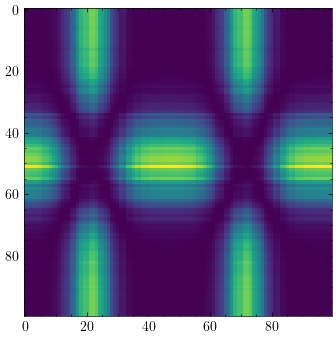

In [11]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(C)
plt.show()

## Dual formulation


$$\sup_{\psi, \phi} \big\{ \sum_j\psi_j\nu_j + \int_X \phi(x) d\mu(x) : \psi_j + \phi(x) \leq c(x, y_j) \big\}$$

which is equivalent to

$$\sup_{\psi} \big\{ \sum_j\psi_j\nu_j + \int_X \inf_{j}[c(x, y_j) - \psi_j] d\mu(x) \big\}$$

It can be solved with a gradient ascent algorithm

## Gradient ascent algorithm

**Objective function**

$$J(\psi) = \sum_j \psi_j \nu_j + \int_X \inf_j [c(x, y_j) - \psi_j]d\mu(x)$$
with $\psi = (\psi_1, \psi_2, \ldots, \psi_N) \in R^N$

In [12]:
# Objective function
# Return the value of the objective function, arginf(c(x,y_j) - psi_j) and phi
def obj(psi, M=M, nu=y, N=N, C=C):
    r = 0.
    for j in range(N):
        r += psi[j] * nu[j]
    inf_j = np.zeros(M)
    phi = np.zeros(M)
    for i in range(M):
        j_star = np.random.randint(N)
        min_value = C[i, j_star] - psi[j_star]
        nn = list(range(N))
        shuffle(nn)
        for j in nn:
            if (C[i, j] - psi[j] < min_value):
                min_value = C[i, j] - psi[j]
                j_star = j
        inf_j[i] = j_star
        r += min_value * x[i]
        phi[i] = min_value
    return r, inf_j, phi

**Gradient of the objective function**

$$\nabla J (\psi) = \left( \frac{\delta J}{\delta \psi_1}, \frac{\delta J}{\delta \psi_2},
    \ldots, \frac{\delta J}{\delta \psi_N} \right) = \left( \ldots, \frac{\delta J}{\delta \psi_k}, \ldots \right)$$

with $k = 1, 2, \ldots, N$

$$
\begin{align}
\frac{\delta J}{\delta \psi_k} &= \frac{\delta J}{\delta \psi_k} \sum_j \psi_j \nu_j + \int_X \inf_j [c(x, y_j) - \psi_j]d\mu(x)\\
    &= \frac{\delta J}{\delta \psi_k} \sum_j \psi_j \nu_j + \sum_i \inf_j [c(x_i, y_j) - \psi_j]x_i\\
    &= \nu_k + \frac{\delta J}{\delta \psi_k} \sum_i [c(x_i, y_{j_i^{*}}) - \psi_{j_i^{*}}]x_i\\
\end{align}
$$

where $j_i^{*} = \arg \inf c(x_i, y_j) - \psi_j$

$$
\begin{align}
\frac{\delta J}{\delta \psi_k} &= \nu_k + \sum_i \frac{\delta J}{\delta \psi_k} [c(x_i, y_{j_i^{*}}) - \psi_{j_i^{*}}]x_i\\
    &= \nu_k - \sum_i \delta_{k j_i^{*}} x_i\\
\end{align}
$$

where $\delta_{k j_i^{*}} = [k = j_i^{*}]$ is the dirac delta function

Thus

$$\nabla J (\psi) = \left( \ldots \nu_k - \sum_i \delta_{k j_i^{*}} x_i \ldots \right)$$ 

In [13]:
# Gradient of J
# Here it doesn't depend on the parameter psi
def grad_obj(inf_index, M=M, N=N, nu=y):
    grad = np.zeros(N)
    for k in range(N):
        grad[k] = nu[k]
        for i in range(M):
            if k == inf_index[i]:
                grad[k] -= x[i]
    return grad

**Gradient ascent algorithm**

In [14]:
def solve(lr = 1e-3, epochs = 100,eps = 1e-5):
    psi_0 = np.ones(N)
    loss_0, inf_index, phi = obj(psi_0)
    print(f"Epoch 0 Loss = {loss_0}")
    hist = [loss_0]
    for epoch in range(epochs):
        grad = grad_obj(inf_index)
        psi_1 = psi_0 + lr * grad
        loss_1, inf_index, phi = obj(psi_1)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} Loss = {loss_1}")
        if (abs(loss_1 - loss_0) < eps):
            print(f"Converged after {epoch} epochs")
            break
        psi_0 = psi_1
        loss_0 = loss_1
        hist.append(loss_1)
    return psi_1, phi, loss_1, hist

In [15]:
psi, phi, loss, _ = solve(1e-2, epochs = 1000, eps=1e-5)

Epoch 0 Loss = 3.921795166284697e-07
Epoch 0 Loss = -0.00025469844275138057
Converged after 26 epochs


# Optimal transportation map

$$\gamma \in \Gamma(x, y)$$

such that

$$\gamma(x) = x - \nabla \phi(x) = x_i - \phi_i + \phi_{i-1}$$

$$\gamma(y) = y - \nabla \psi_j = \nu_j - \psi_j + \psi_{j-1}$$

$\gamma(x)$ should be as close as possible to $\mu(x)$ and $\gamma(y)$ should be as close as possible to $\nu$

In [16]:
dphi =  np.zeros(M)
for i in range(1, M):
    dphi[i] = (phi[i] - phi[i - 1])

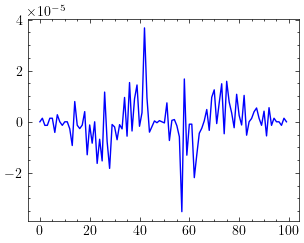

In [17]:
plt.plot(dphi, color = "blue")
plt.show()

In [18]:
dpsi =  np.zeros(N)
for i in range(1, N):
    dpsi[i] = psi[i] - psi[i - 1]

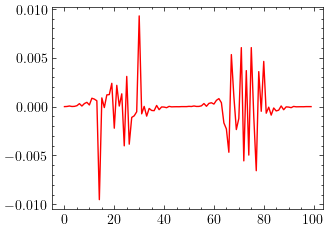

In [19]:
plt.plot(dpsi, color = "red")
plt.show()

In [20]:
gamma = np.zeros((M, N))
for i in range(M):
    for j in range(N):
        gamma[i, j] = y[j] - dpsi[j] + x[i] - dphi[i]

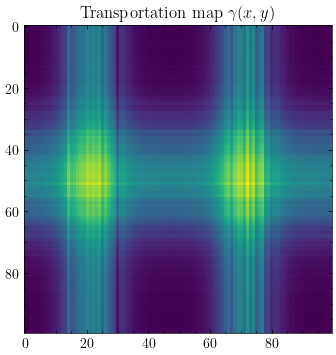

In [21]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(gamma)
plt.title("Transportation map $\gamma(x, y)$")
plt.show()

**compare $\gamma(x)$ and $\nu$**

In [22]:
gamma_y = np.zeros(N)
for j in range(N):
    for i in range(M):
        gamma_y[j] += gamma[i, j]
gamma_y /= gamma_y.sum()

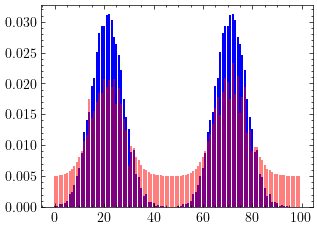

In [23]:
plt.bar(range(N), y, color = "blue")
plt.bar(range(N), gamma_y, color = "red", alpha = .5)
plt.show()

**Compare $\gamma(y)$ and $\mu(x)$**

In [24]:
gamma_x = np.zeros(M)
for i in range(M):
    for j in range(N):
        gamma_x[i] += gamma[i, j]
gamma_x /= gamma_x.sum()

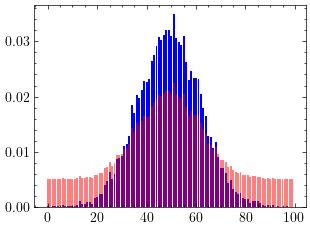

In [25]:
plt.bar(range(M), x, color = "blue")
plt.bar(range(M), gamma_x, color = "red", alpha = .5)
plt.show()

## References

1. **Optimal Transport for Applied Mathematicians** by Filippo Santambrogio
2. **[Le transport optimal: de Gaspard Monge à la science des données](https://speakerdeck.com/gpeyre/le-transport-optimal-de-gaspard-monge-a-la-science-des-donnees)** by Gabriel Peyré